# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
%%bash
if [ -e /content/Mask_RCNN_forked ]; then
    rm -R /content/Mask_RCNN_forked
fi
if [ -e /content/Mask_RCNN ]; then
    rm -R /content/Mask_RCNN
fi

In [3]:
%cd /content/
# !git clone https://github.com/matterport/Mask_RCNN.git
!git clone https://github.com/ttnok/Mask_RCNN_forked.git Mask_RCNN

/content
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 995 (delta 19), reused 18 (delta 8), pack-reused 956
Receiving objects: 100% (995/995), 118.35 MiB | 40.96 MiB/s, done.
Resolving deltas: 100% (585/585), done.


In [4]:
%cd Mask_RCNN
!pip install -r requirements.txt
!pip install japanize-matplotlib


# setup.pyを実行
%run -i setup.py install

/content/Mask_RCNN
     |████████████████████████████████| 163kB 3.9MB/s 
     |████████████████████████████████| 204kB 29.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d4390bee9abb0aa501d18663ee48853667df23f0117656535452c347e9d89c67
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
     |████████████████████████████████| 4.1MB 2.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=8652c924750238f7a0f0188b701454dad842623e709cbcac205979aa16b7c49f
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/m

zip_safe flag not set; analyzing archive contents...


creating dist
creating 'dist/mask_rcnn-2.1-py3.6.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing mask_rcnn-2.1-py3.6.egg
Copying mask_rcnn-2.1-py3.6.egg to /usr/local/lib/python3.6/dist-packages
Adding mask-rcnn 2.1 to easy-install.pth file

Installed /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Processing dependencies for mask-rcnn==2.1
Finished processing dependencies for mask-rcnn==2.1


In [5]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)
Using TensorFlow backend.


... done downloading pretrained model!


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [7]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [8]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', '人', '自転車', '車', 'オートバイ', '飛行機',
               'バス', '列車', 'トラック', 'ボート', '信号機',
               '消火器', 'とまれ', 'パーキングメーター', 'ベンチ', 'トリ',
               'ネコ', 'イヌ', 'ウマ', 'ヒツジ', 'ウシ', 'ゾウ', 'クマ',
               'シマウマ', 'キリン', 'リュック', '傘', 'ハンドバッグ', 'ネクタイ',
               'スーツケース', 'フリスビー', 'スキー', 'スノーボード', 'ボール',
               '凧', 'バット', 'グローブ', 'スケートボード',
               'サーフボード', 'テニスラケット', 'ボトル', 'ワイングラス', 'カップ',
               'フォーク', 'ナイフ', 'スプーン', 'お椀', 'バナナ', 'リンゴ',
               'サンドイッチ', 'ミカン', 'ブロッコリ', 'ニンジン', 'ホットドッグ', 'ピザ',
               'ドーナツ', 'ケーキ', '椅子', 'ソファー', '鉢植え', 'ベッド',
               '食卓', 'トイレ', 'テレビ', 'ノートパソコン', 'マウス', 'リモコン',
               'キーボード', '携帯電話', '電子レンジ', 'オーブン', 'トースター',
               'シンク', '冷蔵庫', '本', '時計', '花瓶', 'ハサミ',
               'テディーベアー', 'ドライヤー', '歯ブラシ']

## Run Object Detection

Processing 1 images
image                    shape: (626, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


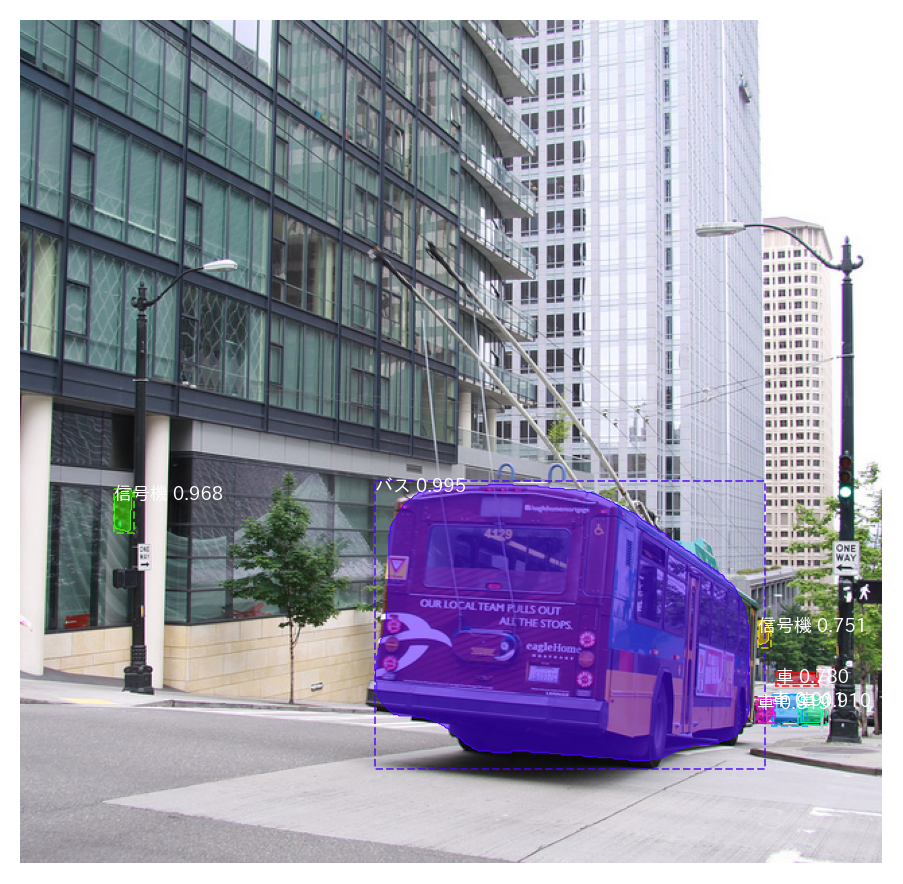

In [9]:
plt.rcParams["font.size"] = 18


# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])